In [2]:
import numpy as np
import pandas as pd

r = 0.05  # constant short rate
sigma = 0.5  # volatility factor


def generate_sample_data(rows, cols, freq='1min'):
    '''
    Function to generate sample financial data.
Parameters
    ==========
    rows: int
        number of rows to generate
    cols: int
        number of columns to generate
    freq: str
        frequency string for DatetimeIndex

    Returns
    =======
    df: DataFrame
        DataFrame object with the sample data
    '''
    rows = int(rows)
    cols = int(cols)
    # generate a DatetimeIndex object given the frequency
    index = pd.date_range('2021-1-1', periods=rows, freq=freq)
    # determine time delta in year fractions
    dt = (index[1] - index[0]) / pd.Timedelta(value='365D')
    # generate column names
    columns = ['No%d' % i for i in range(cols)]
    # generate sample paths for geometric Brownian motion
    raw = np.exp(np.cumsum((r - 0.5 * sigma ** 2) * dt +
                 sigma * np.sqrt(dt) *
                 np.random.standard_normal((rows, cols)), axis=0))
    # normalize the data to start at 100
    raw = raw / raw[0] * 100
    # generate the DataFrame object
    df = pd.DataFrame(raw, index=index, columns=columns)
    return df


if __name__ == '__main__':
    rows = 5  # number of rows
    columns = 3  # number of columns
    freq = 'D'  # daily frequency
    print(generate_sample_data(rows, columns, freq))

                   No0         No1         No2
2021-01-01  100.000000  100.000000  100.000000
2021-01-02   97.790988   96.522807  100.664391
2021-01-03   98.747607   96.869401   99.235551
2021-01-04   98.774327   96.414039   96.782972
2021-01-05   98.171509   94.655763   98.437726


In [3]:
#The following Python script generates sample financial time series data based on a Monte Carlo simulation for a geometric Brownian motion;


r = 0.05  # constant short rate
sigma = 0.5  # volatility factor

def generate_sample_data(rows, cols, freq='1min'):
    '''
    Function to generate sample financial data.
Parameters
    ==========
    rows: int
        number of rows to generate
    cols: int
        number of columns to generate
    freq: str
        frequency string for DatetimeIndex

    Returns
    =======
    df: DataFrame
        DataFrame object with the sample data
    '''
    rows = int(rows)
    cols = int(cols)
    # generate a DatetimeIndex object given the frequency
    index = pd.date_range('2021-1-1', periods=rows, freq=freq)
    # determine time delta in year fractions
    dt = (index[1] - index[0]) / pd.Timedelta(value='365D')
    # generate column names
    columns = ['No%d' % i for i in range(cols)]
    # generate sample paths for geometric Brownian motion
    raw = np.exp(np.cumsum((r - 0.5 * sigma ** 2) * dt +
                 sigma * np.sqrt(dt) *
                 np.random.standard_normal((rows, cols)), axis=0))
    # normalize the data to start at 100
    raw = raw / raw[0] * 100
    # generate the DataFrame object given the frequency
    index = pd.date_range('2021-1-1', periods=rows, freq=freq)
    # determine time delta in year fractions
    dt = (index[1] - index[0]) / pd.Timedelta(value='365D')
    # generate column names
    columns = ['No%d' % i for i in range(cols)]
    # generate sample paths for geometric Brownian motion
    raw = np.exp(np.cumsum((r - 0.5 * sigma ** 2) * dt +
                 sigma * np.sqrt(dt) *
                 np.random.standard_normal((rows, cols)), axis=0))
    # normalize the data to start at 100
    raw = raw / raw[0] * 100
    # generate the DataFrame object
    df = pd.DataFrame(raw, index=index, columns=columns)
    return df


if __name__ == '__main__':
    rows = 5  # number of rows
    columns = 3  # number of columns
    freq = 'D'  # daily frequency
    print(generate_sample_data(rows, columns, freq))

                   No0         No1         No2
2021-01-01  100.000000  100.000000  100.000000
2021-01-02  107.106550   99.134147   96.589150
2021-01-03  104.589480   95.987508   96.481644
2021-01-04  104.040448   95.657844   95.988752
2021-01-05  100.721476   97.788473   94.320914


In [4]:
print(generate_sample_data(rows = 5, cols = 4))

                            No0         No1         No2         No3
2021-01-01 00:00:00  100.000000  100.000000  100.000000  100.000000
2021-01-01 00:01:00   99.961145  100.062692  100.073094   99.861829
2021-01-01 00:02:00   99.904560  100.052888  100.097212   99.910755
2021-01-01 00:03:00   99.829349  100.185443  100.152028  100.008057
2021-01-01 00:04:00   99.853550  100.170166  100.107400   99.871878


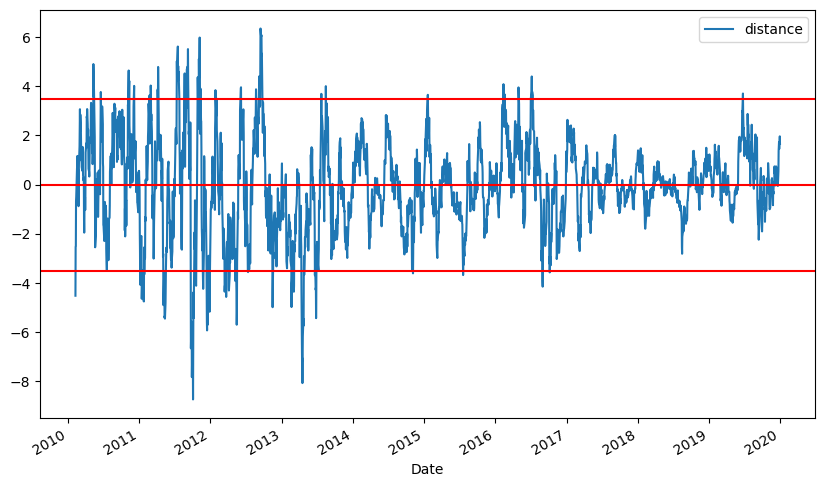

In [5]:
import matplotlib.pyplot as plt
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv', index_col = 0, parse_dates = True).dropna()

data = pd.DataFrame(raw['GDX'])
data.rename(columns = {'GDX': 'price'}, inplace = True)

data['returns'] = np.log(data['price'] / data['price'].shift(1))
SMA = 25

data['SMA'] = data['price'].rolling(SMA).mean()
threshold = 3.5

data['distance'] = data['price'] - data['SMA']

data['distance'].dropna().plot(figsize = (10, 6), legend = True)  
plt.axhline(threshold, color='r')
plt.axhline(-threshold, color='r')
plt.axhline(0, color = 'r');

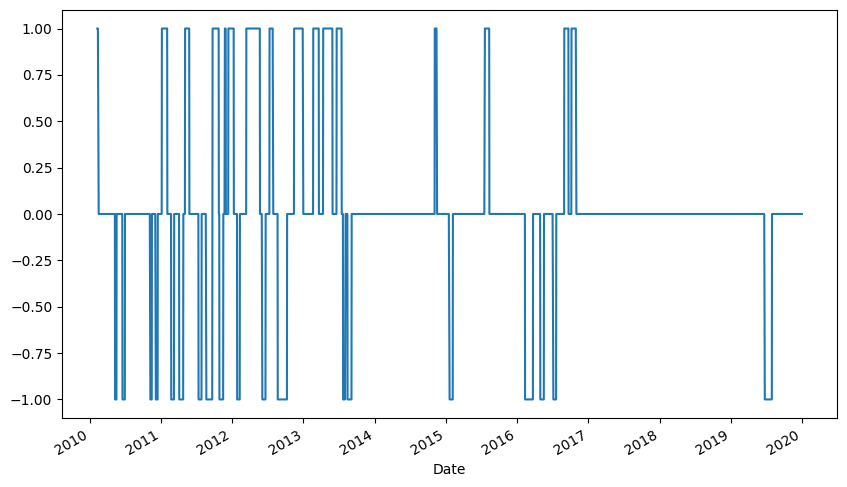

In [6]:
data['position'] = np.where(data['distance'] > threshold,
                                      -1, np.nan)  

data['position'] = np.where(data['distance'] < -threshold,
                                      1, data['position'])  

data['position'] = np.where(data['distance'] *
                      data['distance'].shift(1) < 0, 0, data['position'])  

data['position'] = data['position'].ffill().fillna(0)  

data['position'].iloc[SMA:].plot(ylim=[-1.1, 1.1],
                                         figsize=(10, 6));

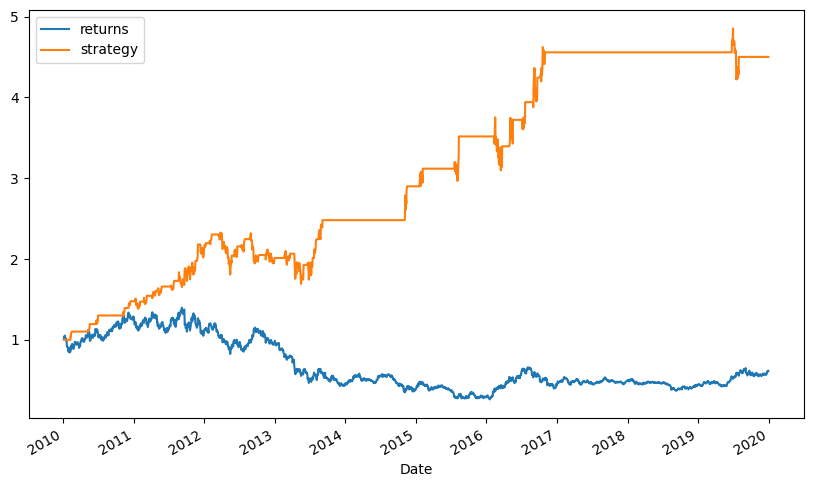

In [7]:
data['strategy'] = data['position'].shift(1) * data['returns']

data[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6));

In [8]:
class MomVectorBacktester(object):
    ''' Class for the vectorized backtesting of
    momentum-based trading strategies.

    Attributes
    ==========
    symbol: str
       RIC (financial instrument) to work with
    start: str
        start date for data selection
    end: str
        end date for data selection
    amount: int, float
        amount to be invested at the beginning
    tc: float
        proportional transaction costs (e.g., 0.5% = 0.005) per trade

    Methods
    =======
    get_data:
        retrieves and prepares the base data set
    run_strategy:
        runs the backtest for the momentum-based strategy
    plot_results:
        plots the performance of the strategy compared to the symbol
    '''

    def __init__(self, symbol, start, end, amount, tc):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.amount = amount
        self.tc = tc
        self.results = None
        self.get_data()

    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                          index_col=0, parse_dates=True).dropna()
        raw = pd.DataFrame(raw[self.symbol])
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: 'price'}, inplace=True)
        raw['return'] = np.log(raw / raw.shift(1))
        self.data = raw

    def run_strategy(self, momentum=1):
        ''' Backtests the trading strategy.
        '''
        self.momentum = momentum
        data = self.data.copy().dropna()
        data['position'] = np.sign(data['return'].rolling(momentum).mean())
        data['strategy'] = data['position'].shift(1) * data['return']
        # determine when a trade takes place
        data.dropna(inplace=True)
        trades = data['position'].diff().fillna(0) != 0
        # subtract transaction costs from return when trade takes place
        data['strategy'][trades] -= self.tc
        data['creturns'] = self.amount * data['return'].cumsum().apply(np.exp)
        data['cstrategy'] = self.amount * \
            data['strategy'].cumsum().apply(np.exp)
        self.results = data
        # absolute performance of the strategy
        aperf = self.results['cstrategy'].iloc[-1]
        # out-/underperformance of strategy
        operf = aperf - self.results['creturns'].iloc[-1]
        return round(aperf, 2), round(operf, 2)

    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to the symbol.
        '''
        if self.results is None:
            print('No results to plot yet. Run a strategy.')
        title = '%s | TC = %.4f' % (self.symbol, self.tc)
        self.results[['creturns', 'cstrategy']].plot(title=title,
                                                     figsize=(10, 6))


if __name__ == '__main__':
    mombt = MomVectorBacktester('XAU=', '2010-1-1', '2020-12-31',
                                10000, 0.0)
    print(mombt.run_strategy())
    print(mombt.run_strategy(momentum=2))
    mombt = MomVectorBacktester('XAU=', '2010-1-1', '2020-12-31',
                                10000, 0.001)
    print(mombt.run_strategy(momentum=2))  

(4513.72, -9047.36)
(7402.01, -5922.63)
(3157.41, -10167.23)


In [9]:
class MRVectorBacktester(MomVectorBacktester):
    ''' Class for the vectorized backtesting of
    mean reversion-based trading strategies.

    Attributes
    ==========
    symbol: str
        RIC symbol with which to work
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    amount: int, float
    amount to be invested at the beginning
    tc: float
        proportional transaction costs (e.g., 0.5% = 0.005) per trade

    Methods
    =======
    get_data:
        retrieves and prepares the base data set
    run_strategy:
        runs the backtest for the mean reversion-based strategy
    plot_results:
        plots the performance of the strategy compared to the symbol
    '''

    def run_strategy(self, SMA, threshold):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data['sma'] = data['price'].rolling(SMA).mean()
        data['distance'] = data['price'] - data['sma']
        data.dropna(inplace=True)
        # sell signals
        data['position'] = np.where(data['distance'] > threshold,
                                    -1, np.nan)
        # buy signals
        data['position'] = np.where(data['distance'] < -threshold,
                                    1, data['position'])
        # crossing of current price and SMA (zero distance)
        data['position'] = np.where(data['distance']
        *
                                    data['distance'].shift(1) < 0,
                                    0, data['position'])
        data['position'] = data['position'].ffill().fillna(0)
        data['strategy'] = data['position'].shift(1) * data['return']
        # determine when a trade takes place
        trades = data['position'].diff().fillna(0) != 0
        # subtract transaction costs from return when trade takes place
        data['strategy'][trades] -= self.tc
        data['creturns'] = self.amount * \
            data['return'].cumsum().apply(np.exp)
        data['cstrategy'] = self.amount * \
            data['strategy'].cumsum().apply(np.exp)
        self.results = data
        # absolute performance of the strategy
        aperf = self.results['cstrategy'].iloc[-1]
        # out-/underperformance of strategy
        operf = aperf - self.results['creturns'].iloc[-1]
        return round(aperf, 2), round(operf, 2)


if __name__ == '__main__':
    mrbt = MRVectorBacktester('GDX', '2010-1-1', '2020-12-31',
                              10000, 0.0)
    print(mrbt.run_strategy(SMA=25, threshold=5))
    mrbt = MRVectorBacktester('GDX', '2010-1-1', '2020-12-31',
                              10000, 0.001)
    print(mrbt.run_strategy(SMA=25, threshold=5))
    mrbt = MRVectorBacktester('GLD', '2010-1-1', '2020-12-31',
                              10000, 0.001)
    print(mrbt.run_strategy(SMA=42, threshold=7.5))

(19031.64, 11851.65)
(18654.78, 11474.79)
(13104.59, 210.97)


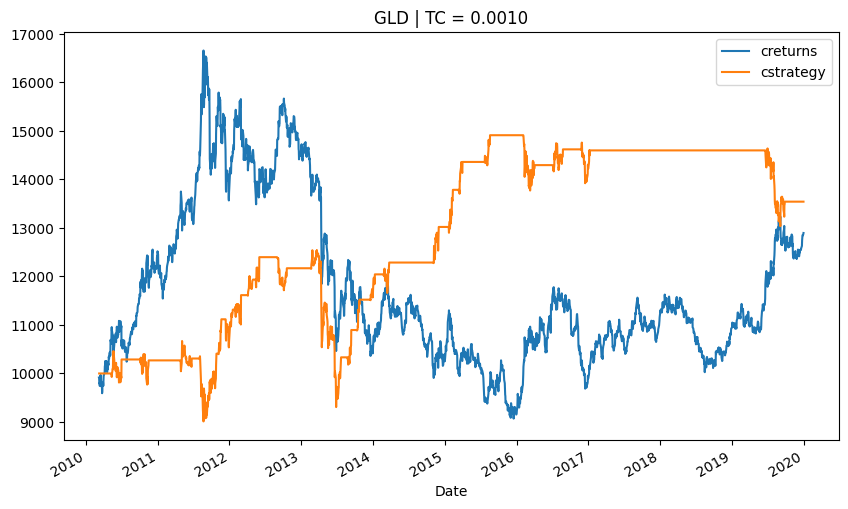

In [10]:
mrbt = MRVectorBacktester('GLD', '2010-1-1', '2019-12-31', 10000, 0.001)  

mrbt.run_strategy(SMA=43, threshold=7.5)
mrbt.plot_results()